<a href="https://colab.research.google.com/github/RiccardoZappa/CellSegmentation/blob/main/Project04_CellSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project : Cell image segmentation projects

Contact: Elena Casiraghi (University Milano elena.casiraghi@unimi.it)

Cell segmentation is usually the first step for downstream single-cell analysis in microscopy image-based biology and biomedical research. Deep learning has been widely used for cell-image segmentation.
The CellSeg competition aims to benchmark cell segmentation methods that could be applied to various microscopy images across multiple imaging platforms and tissue types for cell Segmentation. The  Dataset challenge organizers provide both labeled images and unlabeled ones.
The “2018 Data Science Bowl” Kaggle competition provides cell images and their masks for training cell/nuclei segmentation models.

In 2022 another [Cell Segmentation challenge was proposed at Neurips](https://neurips22-cellseg.grand-challenge.org/).
For interested readers, the competition proceeding has been published on [PMLR](https://proceedings.mlr.press/v212/)

### Project Description

In the field of (bio-medical) image processing, segmentation of images is typically performed via U-Nets [1,2].

A U-Net consists of an encoder - a series of convolution and pooling layers which reduce the spatial resolution of the input, followed by a decoder - a series of transposed convolution and upsampling layers which increase the spatial resolution of the input. The encoder and decoder are connected by a bottleneck layer which is responsible for reducing the number of channels in the input.
The key innovation of U-Net is the addition of skip connections that connect the contracting path to the corresponding layers in the expanding path, allowing the network to recover fine-grained details lost during downsampling.

<img src='https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png' width="400"/>


At this [link](https://rpubs.com/eR_ic/unet), you find an R implementation of basic U-Nets. At this [link](https://github.com/zhixuhao/unet), you find a Keras implementation of UNets.  
Other implementations of more advanced UNets are also made available in [2] at these links: [UNet++](https://github.com/MrGiovanni/UNetPlusPlus)
and by the CellSeg organizers as baseline models: [https://neurips22-cellseg.grand-challenge.org/baseline-and-tutorial/](https://neurips22-cellseg.grand-challenge.org/baseline-and-tutorial/)


### Project aim

The aim of the project is to download the *gray-level* (.tiff or .tif files) cell images from the [CellSeg](https://neurips22-cellseg.grand-challenge.org/dataset/) competition and assess the performance of an UNet or any other Deep model for cell segmentation.
We suggest using gray-level images to obtain a model that is better specified on a sub class of images.

Students are not restricted to use UNets but may other model is wellcome; e.g., even transformer based model in the [leaderboard](https://neurips22-cellseg.grand-challenge.org/evaluation/testing/leaderboard/) may be tested.
Students are free to choose any model, as long as they are able to explain their rationale, architecture, strengths and weaknesses.



### References

[1] Ronneberger, O., Fischer, P., Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. In: Navab, N., Hornegger, J., Wells, W., Frangi, A. (eds) Medical Image Computing and Computer-Assisted Intervention – MICCAI 2015. MICCAI 2015. Lecture Notes in Computer Science(), vol 9351. Springer, Cham. https://doi.org/10.1007/978-3-319-24574-4_28

[2] Long, F. Microscopy cell nuclei segmentation with enhanced U-Net. BMC Bioinformatics 21, 8 (2020). https://doi.org/10.1186/s12859-019-3332-1


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Step 1: Install and Import Necessary Libraries
# ===============================================
!pip install -q tifffile scikit-image
# Install the imagecodecs package to handle LZW compressed TIFF files
!pip install -q imagecodecs

import os
import numpy as np
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
import warnings
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.layers import RandomFlip, RandomRotation

print("All libraries imported successfully.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 25.0 MB/s eta 0:00:00
All libraries imported successfully.


In [3]:
BASE_PATH = '/content/drive/MyDrive/CellSegmentation/NeurIPS22-CellSeg/'

TRAIN_IMG_DIR = os.path.join(BASE_PATH, 'Training/images/')
TRAIN_LBL_DIR = os.path.join(BASE_PATH, 'Training/labels/')

# We will use the 'Tuning' folder as our validation set
VAL_IMG_DIR = os.path.join(BASE_PATH, 'Tuning/images/')
VAL_LBL_DIR = os.path.join(BASE_PATH, 'Tuning/labels/')

# Check if the paths exist
if os.path.exists(TRAIN_IMG_DIR) and os.path.exists(VAL_IMG_DIR):
    print("\nDataset paths seem correct.")
    print(f"Training images found: {len(os.listdir(TRAIN_IMG_DIR))}")
    print(f"Validation images found: {len(os.listdir(VAL_IMG_DIR))}")
else:
    print("\n[ERROR] Dataset paths not found. Please check the BASE_PATH variable.")



# Define Constants
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1

def load_and_preprocess_data(image_dir, label_dir):
    """
    Loads images and labels from the specified directories,
    handles mismatched extensions, resizes, and normalizes them.
    """
    image_filenames = sorted(os.listdir(image_dir))

    X_data = []
    Y_data = []

    print(f"Loading data from: {image_dir}")
    for i, filename in enumerate(image_filenames):
        if i % 50 == 0:
            print(f"  Processing image {i}/{len(image_filenames)}")

        # --- Find matching label ---
        base_name = os.path.splitext(filename)[0] # e.g., 'cell_00001'

        # Try to find the label with common mask extensions
        possible_label_paths = [
            os.path.join(label_dir, base_name +  '_label.tif'),
            os.path.join(label_dir, base_name + '_label.tiff'),
            os.path.join(label_dir, base_name + '_label.png')
        ]

        lbl_path = None
        for path in possible_label_paths:
            if os.path.exists(path):
                lbl_path = path
                break

        # If no label is found after checking, skip this image
        if lbl_path is None:
            warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
            continue

        # --- Load and process the image ---
        img_path = os.path.join(image_dir, filename)
        try:
            img = imread(img_path)
            # Ensure image is 2D (grayscale)
            if len(img.shape) > 2 and img.shape[2] > 1:
                img = img[:, :, 0]
            elif len(img.shape) == 2: # Already grayscale
                pass
            else: # Single channel image with shape (H, W, 1)
                img = img.squeeze()

            img_resized = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            X_data.append(img_resized)

            # --- Load and process the corresponding label ---
            label = imread(lbl_path)
            if len(label.shape) > 2 and label.shape[2] > 1: # Ensure label is 2D
                label = label[:,:,0]
            label_resized = resize(label, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            Y_data.append(label_resized)

        except Exception as e:
            warnings.warn(f"[ERROR] Could not process file {filename} due to: {e}. Skipping.")

    # Convert lists to numpy arrays
    X_data = np.array(X_data, dtype=np.uint8)
    # Ensure masks are boolean (0 or 1). Anything > 0 becomes 1.
    Y_data = (np.array(Y_data) > 0).astype(np.bool_)

    # Add the channel dimension for the model
    X_data = np.expand_dims(X_data, axis=-1)
    Y_data = np.expand_dims(Y_data, axis=-1)

    return X_data, Y_data

# Load the training and validation data using our corrected function
X_train, Y_train = load_and_preprocess_data(TRAIN_IMG_DIR, TRAIN_LBL_DIR)
X_val, Y_val = load_and_preprocess_data(VAL_IMG_DIR, VAL_LBL_DIR)

print("\nData loading and preprocessing complete.")
if len(X_train) > 0 and len(X_val) > 0:
    print(f"Total training samples loaded: {len(X_train)}")
    print(f"Training data shape (X_train): {X_train.shape}")
    print(f"Training labels shape (Y_train): {Y_train.shape}")
    print(f"\nTotal validation samples loaded: {len(X_val)}")
    print(f"Validation data shape (X_val): {X_val.shape}")
    print(f"Validation labels shape (Y_val): {Y_val.shape}")
else:
    print("\n[ERROR] No data was loaded. Please check your file paths and names.")


Dataset paths seem correct.
Training images found: 1000
Validation images found: 86
Loading data from: /content/drive/MyDrive/CellSegmentation/NeurIPS22-CellSeg/Training/images/
  Processing image 0/1000
  Processing image 50/1000


/tmp/ipython-input-3-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00063.bmp. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-3-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00073.bmp. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-3-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00074.bmp. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-3-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00077.bmp. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-3-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00079.bmp. Skipping.
  warnings.warn(f"[WARNING] No matchi

  Processing image 100/1000
  Processing image 150/1000
  Processing image 200/1000
  Processing image 250/1000
  Processing image 300/1000
  Processing image 350/1000
  Processing image 400/1000
  Processing image 450/1000
  Processing image 500/1000
  Processing image 550/1000
  Processing image 600/1000
  Processing image 650/1000
  Processing image 700/1000
  Processing image 750/1000


/tmp/ipython-input-3-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00758.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-3-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00759.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-3-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00760.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-3-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00763.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-3-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00769.png. Skipping.
  warnings.warn(f"[WARNING] No matchi

  Processing image 800/1000
  Processing image 850/1000


/tmp/ipython-input-3-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00856.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-3-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00866.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-3-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00882.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")


  Processing image 900/1000


/tmp/ipython-input-3-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00927.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-3-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00950.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")


  Processing image 950/1000


/tmp/ipython-input-3-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00955.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-3-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00958.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-3-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00962.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-3-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00983.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-3-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00986.png. Skipping.
  warnings.warn(f"[WARNING] No matchi

Loading data from: /content/drive/MyDrive/CellSegmentation/NeurIPS22-CellSeg/Tuning/images/
  Processing image 0/86
  Processing image 50/86

Data loading and preprocessing complete.
Total training samples loaded: 978
Training data shape (X_train): (978, 128, 128, 1)
Training labels shape (Y_train): (978, 128, 128, 1)

Total validation samples loaded: 86
Validation data shape (X_val): (86, 128, 128, 1)
Validation labels shape (Y_val): (86, 128, 128, 1)


--- Training Set Sample ---


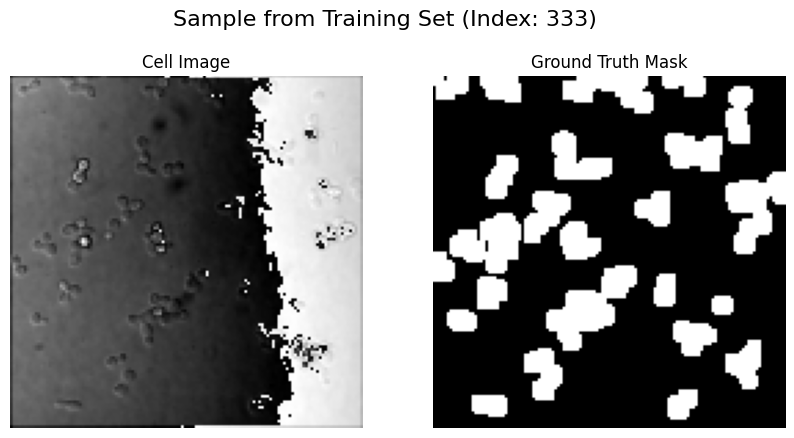


--- Validation Set Sample ---


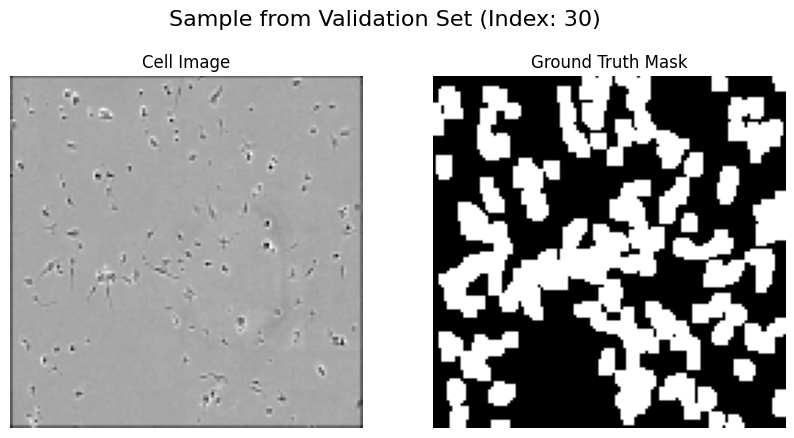

In [4]:
# Step 5: Visualize Samples to Verify
# ====================================

import random

def display_sample(X, Y, dataset_name="Training"):
    """Displays a random sample image and its mask."""
    image_index = random.randint(0, len(X) - 1)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f'Sample from {dataset_name} Set (Index: {image_index})', fontsize=16)

    # Display the image
    ax[0].imshow(X[image_index].squeeze(), cmap='gray')
    ax[0].set_title('Cell Image')
    ax[0].axis('off')

    # Display the mask
    ax[1].imshow(Y[image_index].squeeze(), cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    plt.show()

# Display one sample from the training set
print("--- Training Set Sample ---")
display_sample(X_train, Y_train, "Training")

# Display one sample from the validation set
print("\n--- Validation Set Sample ---")
display_sample(X_val, Y_val, "Validation")

In [11]:
# Step 6: Define the U-Net Model Architecture
# ============================================
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout

def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)

    x = RandomFlip("horizontal_and_vertical")(inputs)
    x = RandomRotation(0.2)(x)

    # --- Encoder (Contracting Path) ---
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # --- Bottleneck ---
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # --- Decoder (Expanding Path) ---
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4]) # Skip Connection
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3]) # Skip Connection
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2]) # Skip Connection
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3) # Skip Connection
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # --- Output Layer ---
    # The output is a 1-channel mask with a sigmoid activation to give a
    # probability (0 to 1) for each pixel being part of a cell.
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Instantiate the model
model = unet_model()
model.summary()

# Step 7: Define Loss Function and Metrics
# ========================================
# For our metric, we will use MeanIoU.
# For our loss, we will use Binary Cross-Entropy, which is standard for
# binary classification problems (is this pixel a cell or not?).
# Adam is a robust, all-purpose optimizer.
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K

# Dice Loss function
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Combined loss function
def total_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=total_loss,
              metrics=[MeanIoU(num_classes=2, name='mean_iou')])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_3       │ (None, 128, 128,  │          0 │ input_layer_3[0]… │
│ (RandomFlip)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_3   │ (None, 128, 128,  │          0 │ random_flip_3[0]… │
│ (RandomRotation)    │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 128, 128,  │        160 │ random_rotation_… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 128, 128,  │          0 │ conv2d_57[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 128, 128,  │      2,320 │ dropout_27[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 64,    │          0 │ conv2d_58[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_12… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 64, 64,    │          0 │ conv2d_59[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 64, 64,    │      9,248 │ dropout_28[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 32, 32,    │          0 │ conv2d_60[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 32, 32,    │          0 │ conv2d_61[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 32, 32,    │     36,928 │ dropout_29[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 16, 16,    │          0 │ conv2d_62[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_14… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 16, 16,    │          0 │ conv2d_63[0][0] 

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Step 8: Define Callbacks and Train the Model
# ============================================
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
# Save the best model based on validation IoU
checkpoint = ModelCheckpoint('best_model.h5',
                             monitor='val_mean_iou',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

# Stop training if validation IoU doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_mean_iou',
                               mode='max',
                               patience=5,
                               verbose=1)

# --- Start Training ---
# We are feeding the training data (X_train, Y_train) and using the
# tuning data (X_val, Y_val) for validation.
print("\nStarting model training...")

# Normalize image data to the [0, 1] range for better training performance
X_train_norm = X_train / 255.0
X_val_norm = X_val / 255.0

history = model.fit(X_train_norm, Y_train,
                    batch_size=16,
                    epochs=50, # Set a high number, EarlyStopping will find the best epoch
                    validation_data=(X_val_norm, Y_val),
                    callbacks=[checkpoint, early_stopping])

print("\nModel training complete.")


Starting model training...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_129']
Received: inputs=Tensor(shape=(None, 128, 128, 1))
  warnings.warn(msg)


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.2515 - mean_iou: 0.3065
Epoch 1: val_mean_iou improved from -inf to 0.27748, saving model to best_model.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - loss: 1.2512 - mean_iou: 0.3065 - val_loss: 1.2238 - val_mean_iou: 0.2775
Epoch 2/50
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.1434 - mean_iou: 0.3108
Epoch 2: val_mean_iou did not improve from 0.27748
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - loss: 1.1426 - mean_iou: 0.3107 - val_loss: 1.1947 - val_mean_iou: 0.2775
Epoch 3/50
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 1.0671 - mean_iou: 0.3021
Epoch 3: val_mean_iou did not improve from 0.27748
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 1.0672 - mean_iou: 0.3023 - val_loss: 1.1845 - val_mean_iou: 0.2775
Epoch 4/50
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 1.0471 - mean_iou: 0.2996
Epoch 4: val_mean_iou did not improve from 0.27748
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 1.0473 - mean_iou: 0.2998 - val_loss: 1.2054 - val_mean_iou: 0.2775
Epoch 5/50
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 1.0140 - mean_iou: 0.3070
Epoch 5: val_mean_iou did not improve fr

In [ ]:
# Step 9: Evaluate Model Performance Quantitatively
# =================================================
# Plot the training and validation loss and IoU

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation loss values
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation Mean IoU values
ax[1].plot(history.history['mean_iou'])
ax[1].plot(history.history['val_mean_iou'])
ax[1].set_title('Model Mean IoU')
ax[1].set_ylabel('Mean IoU')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='lower right')

plt.show()

# Step 10: Evaluate Model Performance Qualitatively
# ==================================================
# Load the best model that was saved during training
model.load_weights('best_model.h5')

# Make predictions on the validation set
preds_val = model.predict(X_val_norm, verbose=1)

# Threshold the predictions to get a binary mask (0 or 1)
# The model outputs probabilities, so we set a threshold of 0.5.
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# Visualize some predictions
def display_predictions(X, Y_true, Y_pred, dataset_name="Validation"):
    """Displays the original image, true mask, and predicted mask."""
    # Pick a random sample
    image_index = random.randint(0, len(X) - 1)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Prediction Sample from {dataset_name} Set (Index: {image_index})', fontsize=16)

    # Display original image (from the non-normalized validation set)
    ax[0].imshow(X[image_index].squeeze(), cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Display ground truth mask
    ax[1].imshow(Y_true[image_index].squeeze(), cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    # Display predicted mask
    ax[2].imshow(Y_pred[image_index].squeeze(), cmap='gray')
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')

    plt.show()

# Show a few random prediction samples
print("\n--- Displaying Prediction Samples ---")
for i in range(3):
    display_predictions(X_val, Y_val, preds_val_t)